<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_RNN_CodeChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### import libraries
import torch
import torch.nn as nn
import numpy as np

# for printing out status reports
import sys

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

### Create temporal sequence data

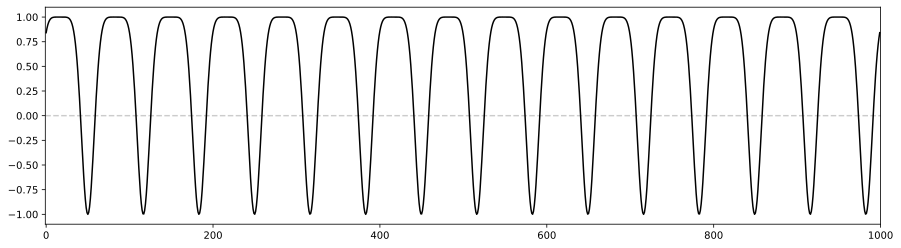

In [2]:
# import the data
N = 1000
t = torch.linspace(0, 30*torch.pi, N)

data = torch.sin(t + torch.cos(t))


plt.figure(figsize=(15, 4))
plt.plot([-1, N+1], [0, 0], '--', color=[.8, .8, .8])
plt.plot(data, 'k-', markerfacecolor='w')
plt.xlim([-1, 1000])
plt.show()

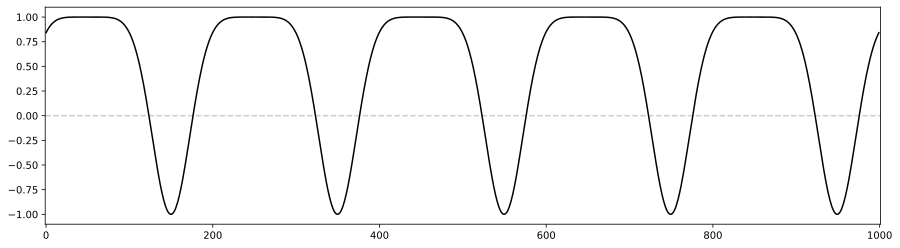

In [3]:
## test data
t = torch.linspace(0, 10*torch.pi, N)

test_data1 = torch.sin(t + torch.cos(t))

plt.figure(figsize=(15, 4))
plt.plot([-1, N+1], [0, 0], '--', color=[.8, .8, .8])
plt.plot(test_data1, 'k-', markerfacecolor='w')
plt.xlim([-1, N+1])
plt.show()

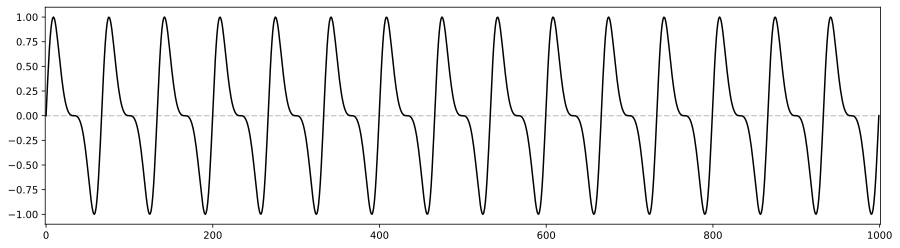

In [4]:
## test data 2
t = torch.linspace(0, 30*torch.pi, N)

test_data2 = torch.sin(t + torch.sin(t))

plt.figure(figsize=(15, 4))
plt.plot([-1, N+1], [0, 0], '--', color=[.8, .8, .8])
plt.plot(test_data2, 'k-', markerfacecolor='w')
plt.xlim([-1, N+1])
plt.show()

## Create a class for the DL model

In [21]:
class rnnnet(nn.Module):
  def __init__(self):
    super().__init__()

    # RNN Layer
    self.rnn = nn.RNN(input_size,num_hidden,num_layers)
    
    # linear layer for output
    self.out = nn.Linear(num_hidden,1)
  
  def forward(self, x, h):
    
    # run through the RNN layer
    y,hidden = self.rnn(x,h)
    
    # and the output (linear) layer
    y = self.out(y)
    
    return y,hidden.detach()

In [23]:
# network parameters
input_size =  1 # "channels" of data
num_hidden =  9 # breadth of model (number of units in hidden layers)
num_layers =  1 # depth of model (number of "stacks" of hidden layers)
seqlength  = 30 # number of datapoints used for learning in each segment
batchsize  =  1 # Note: the training code is actually hard-coded to organize data into batchsize=1

# create an instance of the model and inspect
net = rnnnet()

X = torch.rand(seqlength,batchsize,input_size)
y,h = net(X,None) # None is for empty hidden state input
print(X.shape)
print(y.shape) # note: one output per sequence element; generally, we take the final output to force a "many-to-one" design.
print(h.shape)

torch.Size([30, 1, 1])
torch.Size([30, 1, 1])
torch.Size([1, 1, 9])


In [25]:
# test the model with some data
somedata = data[:seqlength].view(seqlength, 1, 1)
y = net(somedata, None)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]
print(finalValue)

lossfun = nn.MSELoss()
lossfun(finalValue, data[seqlength].view(1, 1))

tensor([[0.0752]], grad_fn=<SelectBackward0>)


tensor(0.7707, grad_fn=<MseLossBackward0>)

### Train the model and show performance

In [26]:
# number of training epochs
numepochs = 30

# create a new instance of the model (and optimizer!)
net = rnnnet()
optimizer = torch.optim.SGD(net.parameters(),lr=.001)



# initialize losses
losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over data segments
  seglosses = []
  segacc    = []
  hiddenstate = None

  for timei in range(N-seqlength):

    # grab a snippet of data
    X = data[timei:timei+seqlength].view(seqlength,1,1)
    y = data[timei+seqlength].view(1,1)

    # forward pass and loss
    yHat,hiddenstate = net(X,hiddenstate)
    finalValue = yHat[-1]
    loss = lossfun(finalValue,y) # compare final value of output

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss from this segment
    seglosses.append(loss.item())
  
  # average losses from this epoch
  losses[epochi] = np.mean(seglosses)
  
  msg = f'Finished epoch {epochi+1}/{numepochs}'
  sys.stdout.write('\r' + msg)

Finished epoch 30/30

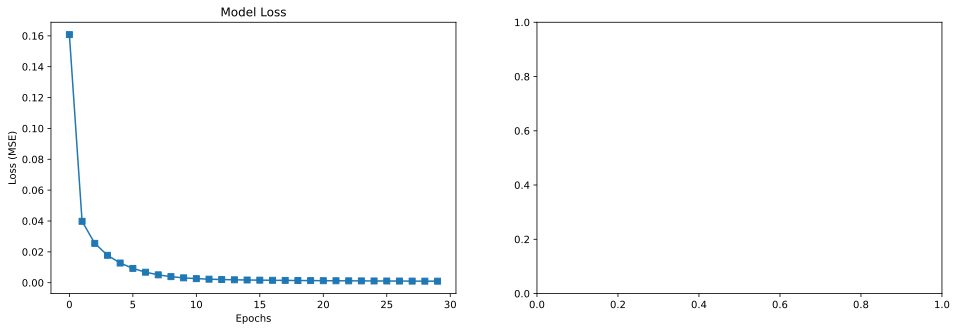

In [9]:
## let's see how the model did!

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses, 's-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model Loss')

plt.show()

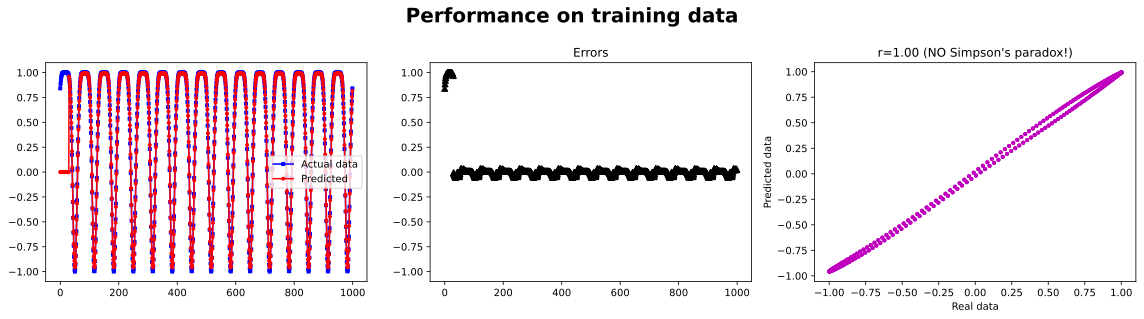

In [27]:
# now test the network!

h = np.zeros((N,num_hidden))

yHat = np.zeros(N)
hh = None
for timei in range(N-seqlength):

  # grab a snippet of data
  X = data[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X,hh)
  yHat[timei+seqlength] = yy[-1]
  h[timei+seqlength,:] = hh.detach()


## plot!
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data',markersize=3)
ax[0].plot(yHat,'ro-',label='Predicted',markersize=3)
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Errors')

ax[2].plot(data[seqlength:],yHat[seqlength:],'mo',markersize=3)
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (NO Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

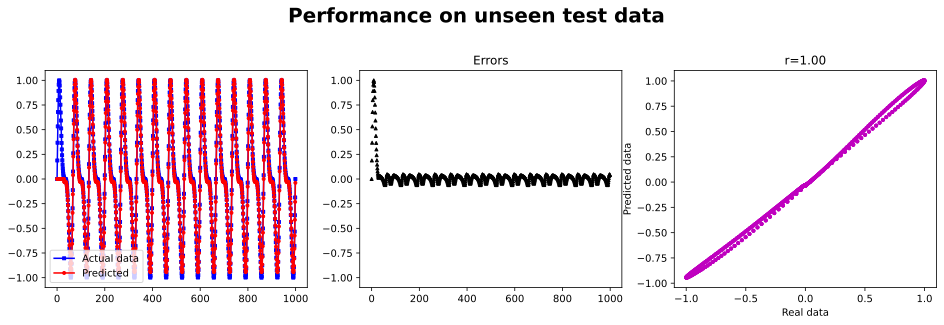

In [30]:
## Create new data (orange case: different frequency)
time = torch.linspace(0,10*np.pi,N)
newdata = torch.sin(time+torch.cos(time))

# Create new data (red case: different function)
time = torch.linspace(0,30*np.pi,N)
newdata = torch.sin(time+torch.sin(time))



# loop over time and predict each subsequent value
yHat = np.zeros(N)
h = None
for timei in range(N-seqlength):

  # grab a snippet of data
  X = newdata[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss (don't need hidden states here)
  yy,h = net(X,h)
  yHat[timei+seqlength] = yy[-1]


# plotting
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(newdata,'bs-',label='Actual data',markersize=3)
ax[0].plot(yHat,'ro-',label='Predicted',markersize=3)
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(newdata-yHat,'k^',markersize=3)
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Errors')

ax[2].plot(newdata[seqlength:],yHat[seqlength:],'mo',markersize=3)
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(newdata[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f}")

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20,y=1.1)
plt.show()

ValueError: ignored

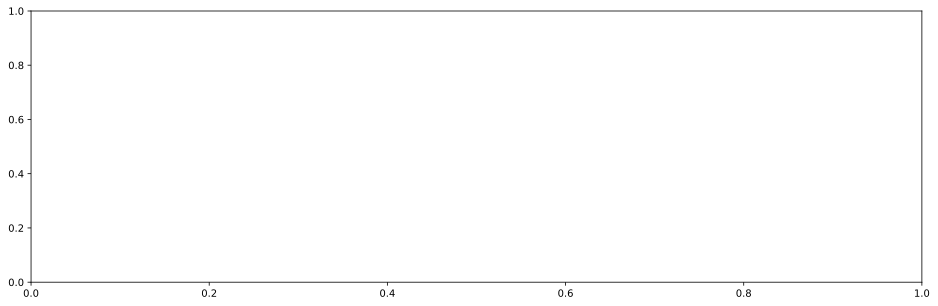

In [31]:
# show the hidden "states" (units activations)
plt.figure(figsize=(16, 5))

plt.plot(h, 's-', markersize=3)
plt.xlabel('Sequence index')
plt.ylabel('State value(a.u)')
plt.title('Each line is a different hidden unit')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/lib/stride_tricks.py:536: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/local/lib/python3.7/dist-packages/numpy/lib/stride_tricks.py:536: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


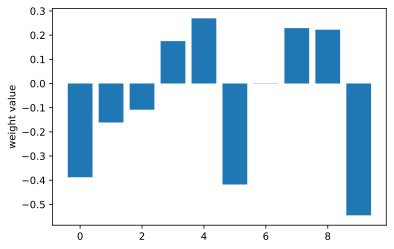

In [16]:
# plot the weights for the input->hidden layers
plt.bar(range(num_hidden), net.rnn.weight_ih_l0.detach())
plt.ylabel('weight value')
plt.show()

## Longer-term Extrapolation

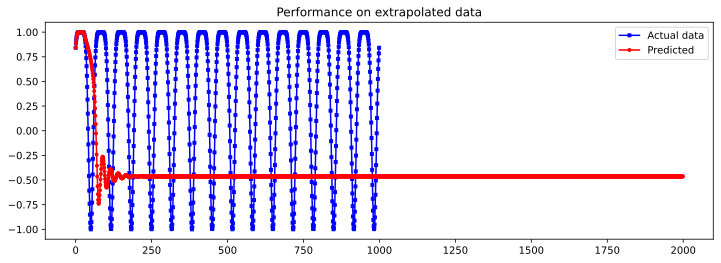

In [32]:
# using original data

# create a signal 2x as long
yHat = torch.zeros(2*N) # torch, not np!
yHat[:N] = data
h = None

for timei in range(2*N-seqlength):

  # grab a snippet of data
  X = yHat[timei:timei+seqlength].view(seqlength,1,1)
  
  # forward pass and loss
  yy,h = net(X,h)
  yHat[timei+seqlength] = yy[-1]



# convert back to np for plotting
yHat = yHat.detach()

# plotting
fig = plt.figure(figsize=(12,4))
plt.plot(data,'bs-',label='Actual data',markersize=3)
plt.plot(yHat,'ro-',label='Predicted',markersize=3)
plt.ylim([-1.1,1.1])
plt.legend()
plt.title('Performance on extrapolated data')
plt.show()